In [11]:
import sys
import os
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif







import yaml




# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate demographic data and data concerning hospital and ICU stays for patients diagnosed with sepsis according to the Angus criteria (Angus et al, 2001. Epidemiology of severe sepsis in the United States; http://www.ncbi.nlm.nih.gov/pubmed/11445675 )

The query was exported from Porticoto the file PTNT_DEMOG_FIRST24.csv. The data was read into a pandas dataframe lab_events.

## IMPORTING DATA

In [12]:
# patient demographic data includes diagnoses and icd9 codes for each patient and each icustay

ptnt_demog = pd.DataFrame.from_csv('PTNT_DEMOG_FIRST24.csv')
ptnt_demog2 = ptnt_demog[~ptnt_demog.index.duplicated(keep='first')].copy()
print "imported"

imported


In [13]:

print "patient demographics with unique icustays"


# create patient demographic table with unique icustays as rows

dates_and_times = ['dob', 'admittime', 'dischtime', 'intime', 'outtime', 'deathtime']
for thing in dates_and_times:
    print "converting {}".format(thing)
    new_series = pd.to_datetime(ptnt_demog2.loc[:,thing])
    ptnt_demog2.loc[:,thing] = new_series
    
    '''
    rows = ptnt_demog2.index
    for row in rows:
        ptnt_demog2.loc[:,thing] = pd.to_datetime(ptnt_demog2.loc[:,thing])
    '''
print "converted to date times"
display(ptnt_demog2.head())

patient demographics with unique icustays
converting dob
converting admittime
converting dischtime
converting intime
converting outtime
converting deathtime
converted to date times


,hadm_id,subject_id,first_careunit,gender,marital_status,ethnicity,insurance,admission_type,admittime,dischtime,intime,outtime,deathtime,dob,hospital_expire_flag,icd9_code,icd9_code.1,short_title,seq_num
icustay_id,,,,,,,,,,,,,,,,,,,
211552,145834,3,MICU,M,MARRIED,WHITE,Medicare,EMERGENCY,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-20 19:10:11,2101-10-26 20:43:09,NaT,2025-04-11,0,0389,0389,Septicemia NOS,1
294638,185777,4,MICU,F,SINGLE,WHITE,Private,EMERGENCY,2191-03-16 00:28:00,2191-03-23 18:41:00,2191-03-16 00:29:31,2191-03-17 16:46:31,NaT,2143-05-12,0,2763,2763,Alkalosis,4
228232,107064,6,SICU,F,MARRIED,WHITE,Medicare,ELECTIVE,2175-05-30 07:15:00,2175-06-15 16:00:00,2175-05-30 21:30:54,2175-06-03 13:39:54,NaT,2109-06-21,0,40391,40391,Hyp kid NOS w cr kid V,1
220597,150750,9,MICU,M,NaN,UNKNOWN/NOT SPECIFIED,Medicaid,EMERGENCY,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-09 13:07:02,2149-11-14 20:52:14,2149-11-14 10:15:00,2108-01-26,1,431,431,Intracerebral hemorrhage,1
232669,112213,12,SICU,M,MARRIED,WHITE,Medicare,ELECTIVE,2104-08-07 10:15:00,2104-08-20 02:57:00,2104-08-08 02:08:17,2104-08-15 17:22:25,2104-08-20 02:57:00,2032-03-24,1,E8782,E8782,Abn react-anastom/graft,9


In [14]:
print "calculating ages, duration of stays"
# len(pd.date_range()) APPEARS TO TAKE A VERY LONG TIME
for index, row in ptnt_demog2.iterrows():
    if (pd.notnull(row['intime']) & pd.notnull(row['dob'])):
        #age_val = relativedelta(row['intime'], row['dob']).years
        # calculating year end frequency
        age_val = len(pd.date_range(end = row['intime'], start = row['dob'], freq = 'A'))
    else: 
        age_val = np.nan
    if (pd.notnull(row['intime']) & pd.notnull(row['outtime'])):
        #delta_time = relativedelta(row['outtime'], row['intime'])
        #icu_stay_val = delta_time.days*24 + delta_time.hours
        icu_stay_val = len(pd.date_range(end = row['outtime'], start = row['intime'], freq = 'H'))
    else: 
        icu_stay_val = np.nan
    if (pd.notnull(row['admittime']) & pd.notnull(row['dischtime'])):
        #delta_time = relativedelta(row['dischtime'], row['admittime'])
        #hosp_stay_val = delta_time.days*24 + delta_time.hours
        hosp_stay_val = len(pd.date_range(end = row['dischtime'], start = row['admittime'], freq = 'H'))
    else:
        hosp_stay_val = np.nan
    
    ptnt_demog2.set_value(index, 'age', age_val)
    ptnt_demog2.set_value(index, 'icu_stay', icu_stay_val)
    ptnt_demog2.set_value(index, 'hosp_stay', hosp_stay_val)

cols = list(ptnt_demog2.columns)
cols.pop(cols.index('icd9_code'))
cols.pop(cols.index('icd9_code.1'))
cols.pop(cols.index('short_title'))
cols.pop(cols.index('intime'))
cols.pop(cols.index('outtime'))
cols.pop(cols.index('admittime'))
cols.pop(cols.index('dischtime'))
cols.pop(cols.index('seq_num'))
cols.pop(cols.index('dob'))

#cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(0, cols.pop(cols.index('hadm_id')))
cols.insert(1, cols.pop(cols.index('age')))
cols.insert(2, cols.pop(cols.index('icu_stay')))
cols.insert(3, cols.pop(cols.index('hosp_stay')))
cols.insert(len(cols), cols.pop(cols.index('hospital_expire_flag')))
display(cols)


ptnt_demog2 = ptnt_demog2[cols]
print "patient demographics with calculated ages, duration of stays"
display(ptnt_demog2.head())

calculating ages, duration of stays


['hadm_id',
 'age',
 'icu_stay',
 'hosp_stay',
 'subject_id',
 'first_careunit',
 'gender',
 'marital_status',
 'ethnicity',
 'insurance',
 'admission_type',
 'deathtime',
 'hospital_expire_flag']

patient demographics with calculated ages, duration of stays


,hadm_id,age,icu_stay,hosp_stay,subject_id,first_careunit,gender,marital_status,ethnicity,insurance,admission_type,deathtime,hospital_expire_flag
icustay_id,,,,,,,,,,,,,
211552,145834,76.0,146.0,259.0,3,MICU,M,MARRIED,WHITE,Medicare,EMERGENCY,NaT,0
294638,185777,48.0,41.0,187.0,4,MICU,F,SINGLE,WHITE,Private,EMERGENCY,NaT,0
228232,107064,66.0,89.0,393.0,6,SICU,F,MARRIED,WHITE,Medicare,ELECTIVE,NaT,0
220597,150750,41.0,128.0,118.0,9,MICU,M,NaN,UNKNOWN/NOT SPECIFIED,Medicaid,EMERGENCY,2149-11-14 10:15:00,1
232669,112213,72.0,184.0,305.0,12,SICU,M,MARRIED,WHITE,Medicare,ELECTIVE,2104-08-20 02:57:00,1


## DROP OUTLIER AGE VALUES

In [15]:
ptnt_demog2['age'].describe()

count    44152.000000
mean        75.591049
std         54.180978
min         17.000000
25%         54.000000
50%         67.000000
75%         78.000000
max        311.000000
Name: age, dtype: float64

In [16]:
age_replace_vals = list(ptnt_demog2[ptnt_demog2['age'] > 110]['age'].unique())
display(age_replace_vals)

ptnt_demog2['age'].replace(age_replace_vals, np.nan, inplace = True)
ptnt_demog2['age'].dropna().describe()

[300.0,
 305.0,
 302.0,
 301.0,
 303.0,
 310.0,
 306.0,
 307.0,
 304.0,
 311.0,
 308.0,
 309.0]

count    41917.000000
mean        63.597204
std         15.815852
min         17.000000
25%         53.000000
50%         65.000000
75%         76.000000
max         89.000000
Name: age, dtype: float64

## DISPLAY DESCRIPTIVE STATS

In [29]:
ptnt_demog2.columns

Index([u'hospital_expire_flag', u'age', u'icu_stay', u'hosp_stay',
       u'first_careunit', u'gender', u'marital_status', u'ethnicity',
       u'insurance', u'admission_type'],
      dtype='object')

In [17]:
display(ptnt_demog2.icu_stay.dropna().describe())
display(ptnt_demog2.hosp_stay.dropna().describe())
display(ptnt_demog2[ptnt_demog2.icu_stay <= 0])
display(ptnt_demog2[ptnt_demog2.hosp_stay <=0])
icu_stay_low = list(ptnt_demog2[ptnt_demog2['icu_stay'] <=0]['icu_stay'].unique())
age_replace_vals = list(ptnt_demog2[ptnt_demog2['age'] > 110]['age'].unique())

#ptnt_demog2.loc[:,'subject_id'] = ptnt_demog2.index
#ptnt_demog2.index = ptnt_demog2.icustay_id
#ptnt_demog2.drop('icustay_id', axis = 1, inplace = True)
#ptnt_demog2.head()

count    44152.000000
mean       115.544505
std        156.791692
min         25.000000
25%         41.000000
50%         65.000000
75%        120.000000
max       4154.000000
Name: icu_stay, dtype: float64

count    44152.000000
mean       294.413345
std        327.554904
min          0.000000
25%        118.000000
50%        193.000000
75%        349.000000
max       7072.000000
Name: hosp_stay, dtype: float64

,hadm_id,age,icu_stay,hosp_stay,subject_id,first_careunit,gender,marital_status,ethnicity,insurance,admission_type,deathtime,hospital_expire_flag
icustay_id,,,,,,,,,,,,,


,hadm_id,age,icu_stay,hosp_stay,subject_id,first_careunit,gender,marital_status,ethnicity,insurance,admission_type,deathtime,hospital_expire_flag
icustay_id,,,,,,,,,,,,,
269115,146708,50.0,27.0,0.0,74937,MICU,F,MARRIED,WHITE,Private,EMERGENCY,2103-08-12,1


Date and time data imported in string format is converted to pandas.datetime objects

## Extracting diagnoses information using code grabbed from benchmarking exercise

In [18]:
#phenotypes = add_hcup_ccs_2015_groups(diagnoses, yaml.load(open(args.phenotype_definitions, 'r')))
definitions = yaml.load(open('hcup_ccs_2015_definitions.yaml', 'r'))

diagnoses = ptnt_demog[['hadm_id', 'icd9_code', 'short_title']].copy()

# create mapping of hcup_ccs_2015_definitions to diagnoses icd9 codes
def_map = {}
for dx in definitions:
    for code in definitions[dx]['codes']:
        def_map[code] = (dx, definitions[dx]['use_in_benchmark'])

print "map created"
# map hcup_ccs_2015 definitions to icd9 diagnoses codes
diagnoses['HCUP_CCS_2015'] = diagnoses.icd9_code.apply(lambda c: def_map[c][0] if c in def_map else None)
diagnoses['USE_IN_BENCHMARK'] = diagnoses.icd9_code.apply(lambda c: int(def_map[c][1]) if c in def_map else None)
#diagnoses['subject_id'] = diagnoses.index
#diagnoses.set_index(np.arange(diagnoses.shape[0]), inplace = True)


# create dataframe from the def_map dict so that we can isolate the 
# definitions that are used in benchmarking

def_map_df = pd.DataFrame.from_dict(def_map, orient = 'index')
def_map_df.columns = ['Diagnoses', 'Benchmark']
diagnoses_bm = list(def_map_df[def_map_df.Benchmark == True].drop_duplicates('Diagnoses').Diagnoses)
icustays = list(ptnt_demog2.index)

# create dataframe with hcup_ccp diagnoses benchmark categories as columns and
# icustay_id information as indices. if the diagnosis is present for a given icustay the 
# value is 1, otherwise 0. 

diagnoses2 = pd.DataFrame(columns = diagnoses_bm, index = icustays)
diagnoses2.fillna(0, inplace = True)
print "created empty diagnosis dataframe"
for row in diagnoses.iterrows():
    if row[1]['USE_IN_BENCHMARK'] == 1:
        diagnoses2.loc[row[0]][row[1]['HCUP_CCS_2015']] = 1

print "filled diagnosis dataframe"
diagnoses2.head()

map created
created empty diagnosis dataframe
filled diagnosis dataframe


,Diabetes mellitus with complications,Complications of surgical procedures or medical care,Congestive heart failure; nonhypertensive,Diabetes mellitus without complication,Chronic kidney disease,Acute and unspecified renal failure,Acute cerebrovascular disease,Other liver diseases,Hypertension with complications and secondary hypertension,Cardiac dysrhythmias,...,Other lower respiratory disease,Conduction disorders,Chronic obstructive pulmonary disease and bronchiectasis,Pleurisy; pneumothorax; pulmonary collapse,Gastrointestinal hemorrhage,Respiratory failure; insufficiency; arrest (adult),Coronary atherosclerosis and other heart disease,Disorders of lipid metabolism,Shock,Essential hypertension
211552,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294638,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
228232,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
220597,0,0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
232669,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
ptnt_demog2.drop(['subject_id', 'deathtime', 'hadm_id'], inplace = True, axis = 1)
cols = list(ptnt_demog2.columns)
cols.insert(0, cols.pop(cols.index('hospital_expire_flag')))
ptnt_demog2 = ptnt_demog2[cols]


In [28]:
diagnoses.dtypes

hadm_id              int64
icd9_code           object
short_title         object
HCUP_CCS_2015       object
USE_IN_BENCHMARK     int64
dtype: object

In [23]:
diagnoses2.columns


Index([u'Diabetes mellitus with complications',
       u'Complications of surgical procedures or medical care',
       u'Congestive heart failure; nonhypertensive',
       u'Diabetes mellitus without complication', u'Chronic kidney disease',
       u'Acute and unspecified renal failure',
       u'Acute cerebrovascular disease', u'Other liver diseases',
       u'Hypertension with complications and secondary hypertension',
       u'Cardiac dysrhythmias', u'Other upper respiratory disease',
       u'Acute myocardial infarction', u'Fluid and electrolyte disorders',
       u'Septicemia (except in labor)',
       u'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',
       u'Other lower respiratory disease', u'Conduction disorders',
       u'Chronic obstructive pulmonary disease and bronchiectasis',
       u'Pleurisy; pneumothorax; pulmonary collapse',
       u'Gastrointestinal hemorrhage',
       u'Respiratory failure; insufficiency; arrest (adult)',
       u'Co

## CONVERT CONTINUOUS TO CATEGORICAL DATA

"\nearlier versions included these factors but the  process has been iterative so we \npre-selected relevant features above\ndiagnoses2['GCS Total_15', 'GCS Total_3', 'GCS Total_6', 'GCS Total_4', \n                          'Respiratory Failure','Shock', 'Septicemia (except in labor)', 'Acute and unspecified renal failure','Other liver diseases',\n                         'Fluid and electrolyte disorders',\n                          'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',\n                            'Acute cerebrovascular disease']\n"

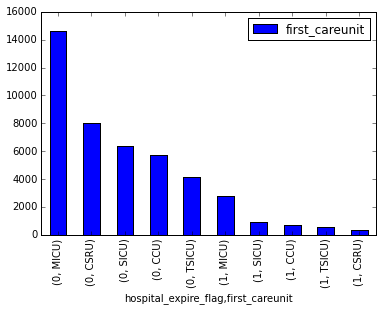

In [24]:
# NEED TO DO SOME OVERVIEW OF DATA INCLUDING DISTRIBUTIONS, SUMMARY STATISTICS ETC
# SINCE WE HAVE SO MUCH DATA, WE ARE JUMPING AHEAD..... IN TIME!! 
# AND SELECTING FEATURES THAT WERE USED IN THE FINAL CLASSIFICATION

demog_select_features_df = ptnt_demog2[['hospital_expire_flag', 'icu_stay', 'age', 'first_careunit', 'admission_type']]
demog_select_features_df.head()

demog_select_features_df[demog_select_features_df.columns[:3]].dropna().groupby('hospital_expire_flag').describe()


pd.DataFrame(demog_select_features_df.groupby('hospital_expire_flag').first_careunit.value_counts()).plot.bar(stacked = True)

icu_admits_df = pd.DataFrame(demog_select_features_df['first_careunit'].value_counts()/demog_select_features_df.shape[0])
icu_admits_df.index

icu_mortality_rates_df = pd.DataFrame(demog_select_features_df.groupby('first_careunit').hospital_expire_flag.sum()/ \
demog_select_features_df.groupby('first_careunit').hospital_expire_flag.count())
icu_admits_df.merge(icu_mortality_rates_df, left_index = True, right_index = True, 
                       how = 'left', sort = True)

demog_select_features_df[demog_select_features_df['first_careunit'] == 'MICU']['first_careunit'].count()



admission_types_df = pd.DataFrame(demog_select_features_df['admission_type'].value_counts()/demog_select_features_df.shape[0])

admission_type_mortality_rates_df = pd.DataFrame(demog_select_features_df.groupby('admission_type').hospital_expire_flag.sum()/ \
demog_select_features_df.groupby('admission_type').hospital_expire_flag.count())

admission_types_df.merge(admission_type_mortality_rates_df, left_index = True, right_index = True, 
                       how = 'left', sort = True)
'''
earlier versions included these factors but the  process has been iterative so we 
pre-selected relevant features above
diagnoses2['GCS Total_15', 'GCS Total_3', 'GCS Total_6', 'GCS Total_4', 
                          'Respiratory Failure','Shock', 'Septicemia (except in labor)', 'Acute and unspecified renal failure','Other liver diseases',
                         'Fluid and electrolyte disorders',
                          'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',
                            'Acute cerebrovascular disease']
'''

In [25]:
def quant_cats(feature, Q1, Q2, Q3):
    if feature <=Q1:
        return 'Q0'
    elif (feature >Q1 and feature <= Q2):
        return 'Q1'
    elif (feature > Q2 and feature <= Q3):
        return 'Q2'
    elif feature > Q3:
        return 'Q3'
    

ptnt_demog3 = ptnt_demog2.copy()
demog_stats = ptnt_demog3[ptnt_demog3.columns[1:4]].dropna().describe()
for col in ptnt_demog3.columns[1:4]:
        Q1 = demog_stats[col].loc['25%']
        Q2 = demog_stats[col].loc['50%']
        Q3 = demog_stats[col].loc['75%']
        ptnt_demog3[col] = ptnt_demog3[col].apply(lambda x: quant_cats(x, Q1, Q2, Q3))



In [26]:
demog_stats

,age,icu_stay,hosp_stay
count,41917.000000,41917.000000,41917.000000
mean,63.597204,116.732591,298.765107
std,15.815852,158.959870,333.093729
min,17.000000,25.000000,0.000000
25%,53.000000,41.000000,119.000000
50%,65.000000,65.000000,195.000000
75%,76.000000,121.000000,355.000000
max,89.000000,4154.000000,7072.000000


## CONVERT CATEGORICAL TO DUMMY VARIABLES

In [32]:
ptnt_demog2.dtypes


hospital_expire_flag      int64
age                     float64
icu_stay                float64
hosp_stay               float64
first_careunit           object
gender                   object
marital_status           object
ethnicity                object
insurance                object
admission_type           object
dtype: object

In [33]:
ptnt_demog3.dtypes


hospital_expire_flag     int64
age                     object
icu_stay                object
hosp_stay               object
first_careunit          object
gender                  object
marital_status          object
ethnicity               object
insurance               object
admission_type          object
dtype: object

In [ ]:
dummies = ptnt_demog2[ptnt_demog3.columns[:1]]

#display(monkey.head())
for col in ptnt_demog3.columns[1:]:
    chimp = pd.get_dummies(ptnt_demog3[col], prefix = col)
    dummies = dummies.merge(chimp, left_index = True, right_index = True, 
                       how = 'left', sort = True)

dummies.head()
    

## MERGE DUMMY VARIABLES AND DIAGNOSES

dummies = dummies.merge(diagnoses2, left_index = True, right_index = True, 
                       how = 'left')
dummies.dropna().shape

In [ ]:
diags2 = list(diagnoses2.columns)
#diags.pop(diags.index('Diabetes mellitus without complication'))
diags = [
 'hospital_expire_flag',
 'Acute cerebrovascular disease',
 'Other liver diseases',
 'Acute and unspecified renal failure',
 'Fluid and electrolyte disorders',
 'Septicemia (except in labor)',
 'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',
 'Respiratory failure; insufficiency; arrest (adult)',
 'Shock'
 ]


plt.subplots(figsize=(13,6))
diags_df = dummies[diags]
#diags_df.head()

diags_df[diags_df.columns[1:]][diags_df['hospital_expire_flag']==1].sum().plot.bar(
        alpha=0.5,label= 'Non_Survival')
diags_df[diags_df.columns[1:]][diags_df['hospital_expire_flag']==0].sum().plot.bar(
        alpha=0.1,label= 'Survival')
    

## SELECT FEATURES AND WRITE TO FILE. 

In [ ]:


root = os.getcwd() + '/features/'
name = 'Ptnt_Demog_Features.csv'
name2 = 'Ptnt_Demog_FeaturesScores.csv'
frame = dummies
X = frame[frame.columns[1:]]
y = frame['hospital_expire_flag']

        
# SELECT K BEST FEATURES BASED ON CHI2 SCORES
selector = SelectKBest(score_func = chi2, k = 'all')
selector.fit(X, y)
p_vals = pd.Series(selector.pvalues_, name = 'p_values', index = X.columns)
scores = pd.Series(selector.scores_, name = 'scores', index = X.columns)
features_df = pd.concat([p_vals, scores], axis = 1)
features_df.sort_values(by ='scores', ascending = False, inplace = True)
print "Feature scores/p_values in descending/ascending order"
display(features_df.head(20))

best_features = frame[features_df[features_df.p_values < .001].index]

frame = pd.DataFrame(y).merge(best_features, left_index = True, right_index = True, 
                how = 'left', sort = True)


print "{}     {}".format(name, frame.shape)


# CODE TO REORDER FEATURES ALPHABETICALLY. MAKES FOR CLEANER COLUMNS, GROUPED BY TYPE
# BUT WHAT WE MAY WANT IS THE ORDER OF FEATURE SIGNIFICANCE PRESERVCED. 
'''
cols = list(frame.columns)
cols.sort()
cols.insert(0, cols.pop(cols.index('hospital_expire_flag')))
frame = frame[cols]
'''

print "head of selected feature frame "
display(frame.head())
frame.to_csv(root + name)
features_df[features_df.p_values < .001].to_csv(root + name2)
y = pd.DataFrame(y)
y.to_csv(root + 'outcomes.csv')